In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
import tensorflow as tf
import scipy.io 
import matplotlib.pyplot as plt
import cv2
import keras
from glob import glob
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import pandas as pd
import cv2

from sklearn.model_selection import KFold
# from keras.preprocessing.image import ImageDataGenerator

# import keras_metrics

from keras.applications import mobilenet, resnet50 #, vgg16, inception_v3, resnet50, 
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, History

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import logging
# logging.getLogger().setLevel(logging.DEBUG)
import pickle


import seaborn
seaborn.set_style("darkgrid")

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


In [3]:
# all_data_dir = 'E:\\Work/PathoBarIlan/Shlomi2018/'
all_data_dir = '/media/leetwito/DATA/Datasets/PathoBarIlan/Shlomi2018'

is_relative_path_csv = False
seed = 4221

pos_name_init = 'Cancer'
neg_name_init = 'Normal'

use_rgb = False # True=rgb, False=spectral
if use_rgb:
    file_ext = '.png'
else:
    file_ext = '.npy'
    
window_size = (200, 200)
shift = (100, 100)

In [4]:
w,h = window_size
if use_rgb:
    input_shape = (w,h,3)
else:
    input_shape = (w,h,40)
batch_size = 16

### loss

In [5]:
path = '/media/leetwito/Windows/Users/leetw/PycharmProjects/PathoBarIlan/my_models/k=2, lr5e-4/losses.txt'
with open(path, 'r') as f:
    lines = f.readlines()

In [6]:
train_loss = []
for line in lines:
#     line = str(line)
    train_loss.append(float(line.split(":")[2][:-1]))

In [7]:
from glob import glob

In [8]:
file_names = glob('/media/leetwito/Windows/Users/leetw/PycharmProjects/PathoBarIlan/my_models/k=2, lr5e-4/*.hdf5')
i=0
int(file_names[i].split("epoch")[1].split("-")[0])
file_names[0]

'/media/leetwito/Windows/Users/leetw/PycharmProjects/PathoBarIlan/my_models/k=2, lr5e-4/model_spec_weights_epoch201-val_loss0.017-seed4221-k_idx=2.hdf5'

In [9]:
val = []
epoch = []
for file in file_names:
    epoch_num = int(file.split("epoch")[1].split("-")[0])
    if epoch_num > 80:
        continue
    val.append(float(file.split("val_loss")[1].split("-")[0]))
    epoch.append(epoch_num)

In [10]:
df = pd.DataFrame({"val_loss":val, "epoch":epoch}).set_index("epoch").sort_index()
dff = pd.DataFrame([0] + train_loss, columns=["train"]).iloc[1:]
dfff = pd.concat([df, dff], axis=1)

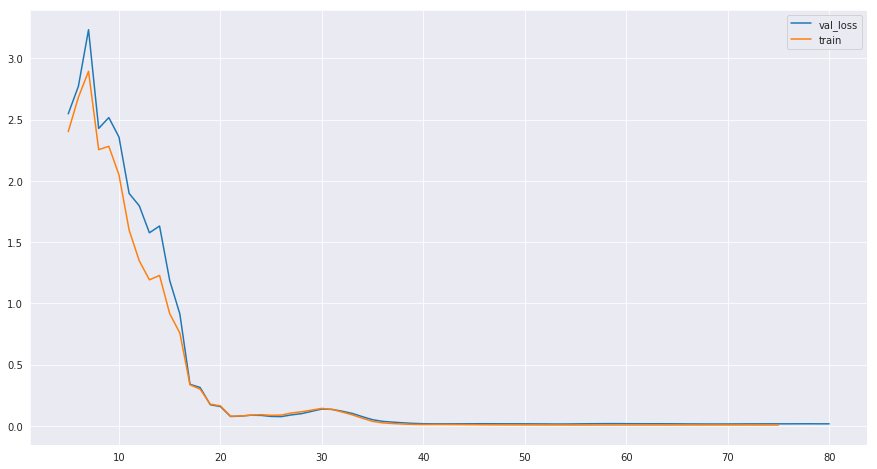

In [11]:
dfff.rolling(5).mean().plot(figsize=(15, 8))

### roc

In [ ]:
folders = glob('/media/leetwito/Windows/Users/leetw/PycharmProjects/PathoBarIlan/my_models/k*')

In [ ]:
def batch_norm(x):
#     print("x.shape:", x.shape)
    maxi = x.max(axis=1).max(axis=1)
#     print("maxi.shape:", maxi.shape)
    maxi = np.repeat(maxi[:, np.newaxis, : ], window_size[0], axis=1)
    maxi = np.repeat(maxi[:, np.newaxis, : ], window_size[1], axis=1)
    return x/maxi


def generator_from_df(df, batch_size, shuffle=True): 
    
    n_batches = df.shape[0]//batch_size
    while True:
        if shuffle:
            df_tmp = df.copy().sample(frac=1)  # frac=1 is same as shuffling df.
        else:
            df_tmp = df
        
        for i in range(n_batches):
            sub = df_tmp.iloc[batch_size*i:batch_size*(i+1)]
#             start = time()
            if use_rgb:
                X = [img_to_array(load_img(f, target_size=input_shape)) for f in sub.filename]
            else:
                X = [np.load(f) for f in sub.filename]
#             end = time()
#             print("batch load time: {}".format(end-start))
            
            X = batch_norm(np.stack(X))
            logging.debug("from file {}\nto file {}".format(sub.iloc[0].filename, sub.iloc[-1].filename))

            Y = sub.label.values
            Y = to_categorical(Y, num_classes=2)
            # Simple model, one input, one output.
            
            yield X, Y
        del df_tmp
        gc.collect()

In [ ]:
def get_y_test_and_pred():
    y_tests = []
    y_preds = []
    for i in range(len(df_test)//batch_size):
        print(i, "out of", len(df_test)//batch_size)
        x, y = next(test_generator)
        print(mobilenet_model.evaluate(x, y))
        y_tests.append(y.argmax(axis=1))
        y_preds.append(mobilenet_model.predict(x)[:,1])
    
    y_test = np.stack(y_tests)
    y_pred = np.stack(y_preds)

    y_test = y_test.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    
    return y_test, y_pred

In [ ]:
mobilenet_model = mobilenet.MobileNet(include_top=True, weights=None, input_shape=input_shape, classes=2, dropout=0.2)
optimizer = Adam(lr=5e-4) # 1e-3
mobilenet_model.compile(loss="binary_crossentropy", optimizer=optimizer) #  binary_crossentropy , categorical_crossentropy
y_trues = []
y_preds = []


for i, folder in enumerate(folders):
    print("\n---------------------------------\n in %d file=%s\n---------------------------------"%(i, folder))
    df_test = pd.read_pickle("df_test_%i"%i)
    test_generator = generator_from_df(df_test, 16, shuffle=False)
    a = glob(folder+"/*.hdf5")
    val = 100
    for model in a:
        tmp_val = (float(model.split("val_loss")[1].split("-")[0]))
        if tmp_val<val:
            file = model
            val = tmp_val
    mobilenet_model.load_weights(file)
    y_test, y_pred = get_y_test_and_pred()
    y_trues.append(y_test)
    y_preds.append(y_pred)

In [ ]:
def plot_roc_curve(y_true, y_scores, figsize=(15, 8)):
    fpr, tpr, threshold = roc_curve(y_true, y_scores)
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axes()

    return fpr, tpr, threshold

In [ ]:
y_trues = [i[:, 0] for i in y_trues] 
y_preds = [i[:, 0] for i in y_preds] 

In [ ]:
y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)

In [ ]:
plot_roc_curve(y_trues, y_preds)

In [ ]:
print(roc_auc_score(y_trues, y_preds))